In [45]:
import csv
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

RANDOM_SEED = 42

In [46]:
dataset_test = 'glove_data_test/glove_test_data.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.tflite'

In [148]:
def augment_data_with_noise(data, noise_scale):
    # Calculate statistics for each column except the first one (assuming it contains labels)
    column_stats = data[:, 1:].mean(axis=0), data[:, 1:].std(axis=0)

    # Generate noise for each column except the first one
    noise = np.random.normal(loc=0, scale=column_stats[1] * noise_scale, size=data[:, 1:].shape)

    # Add noise to each column except the first one
    augmented_data = data.copy()
    augmented_data[:, 1:] += noise

    return augmented_data

directory = 'data_glove'

# Initialize an empty list to store data from all files
data_X = []
data_y = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data_X.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151))))
        data_y.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data_X, axis=0)
y_dataset = np.concatenate(data_y, axis=0)

# Augment data with noise
augmented_data = augment_data_with_noise(X_dataset, 0.1)
augmented_data2 = augment_data_with_noise(X_dataset, 0.01)
augmented_data3 = augment_data_with_noise(X_dataset, 0.005)
augmented_data4 = augment_data_with_noise(X_dataset, 0.05)

X_dataset = np.concatenate([X_dataset, augmented_data, augmented_data2, augmented_data3, augmented_data4], axis=0)
print(X_dataset.shape)

y_dataset = np.concatenate([y_dataset, y_dataset, y_dataset, y_dataset, y_dataset], axis=0)
print(y_dataset.shape)
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

(84000, 172)
(84000,)


In [47]:
NUM_CLASSES = 24

In [122]:
# Directory containing CSV files
directory = 'data_glove'

# Initialize an empty list to store data from all files
data_X = []
data_y = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data_X.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151))))
        data_y.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data_X, axis=0)
y_dataset = np.concatenate(data_y, axis=0)

X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

In [149]:
print("X dataset shape: " + X_dataset.shape.__str__())
print("y dataset shape: " + y_dataset.shape.__str__())
print("----------------------------------")
print("X test dataset shape: " + X_test.shape.__str__())
print("y test dataset shape: " + y_test.shape.__str__())
print("----------------------------------")
print("X dataset train shape: " + X_train.shape.__str__())
print("y dataset train shape: " + y_train.shape.__str__())

X dataset shape: (84000, 172)
y dataset shape: (84000,)
----------------------------------
X test dataset shape: (2400, 172)
y test dataset shape: (2400,)
----------------------------------
X dataset train shape: (58799, 172)
y dataset train shape: (58799,)


In [150]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=10),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

C:\thesis\venv\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [151]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_20 (Reshape)            │ (None, 172, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 172, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_55 (MaxPooling1D) │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_56 (Conv1D)              │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_56 (MaxPooling1D) │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_57 (Conv1D)              │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_57 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,360 (774.84 KB)

 Trainable params: 198,360 (774.84 KB)

 Non-trainable params: 0 (0.00 B)

In [152]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=10),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

C:\thesis\venv\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [153]:
model2.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_21 (Reshape)            │ (None, 172, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_58 (Conv1D)              │ (None, 172, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_58 (MaxPooling1D) │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_59 (Conv1D)              │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_59 (MaxPooling1D) │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_60 (Conv1D)              │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_60 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,328 (915.34 KB)

 Trainable params: 234,328 (915.34 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [155]:
# Model checkpoint callback
cp_callback_test = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback_test = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [156]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [157]:
# Model compilation
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [158]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0935 - loss: 7.5938
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0936 - loss: 7.5864 - val_accuracy: 0.5278 - val_loss: 1.8224
Epoch 2/1000
458/460 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2820 - loss: 2.1850
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2822 - loss: 2.1841 - val_accuracy: 0.6104 - val_loss: 1.2490
Epoch 3/1000
458/460 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3695 - loss: 2.0602
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
460/460 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3696 - loss: 2.0594 - val_accuracy: 0.7005 - val_loss: 0.9878
Epoch 4/1000
455/460 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4296 - loss: 1.6440
Epoch 4: saving model to model/keypoint_

In [159]:
history2 = model2.fit(
    X_train,
    y_train,
    epochs = 1000,
    batch_size = 64,
    validation_data = (X_validation, y_validation),
    callbacks = [cp_callback_test, es_callback_test]
)

Epoch 1/1000
918/919 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1053 - loss: 5.5647
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
919/919 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.1055 - loss: 5.5602 - val_accuracy: 0.5032 - val_loss: 1.6819
Epoch 2/1000
916/919 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3407 - loss: 1.9373
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
919/919 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3408 - loss: 1.9367 - val_accuracy: 0.6753 - val_loss: 0.9922
Epoch 3/1000
915/919 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4787 - loss: 1.4854
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
919/919 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4788 - loss: 1.4853 - val_accuracy: 0.7360 - val_loss: 0.7731
Epoch 4/1000
915/919 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5427 - loss: 1.2340
Epoch 4: saving model to model/keypoin

In [160]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8465 - loss: 0.6512


In [161]:
val_loss2, vall_acc2 = model2.evaluate(X_test, y_test, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8490 - loss: 0.8807


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


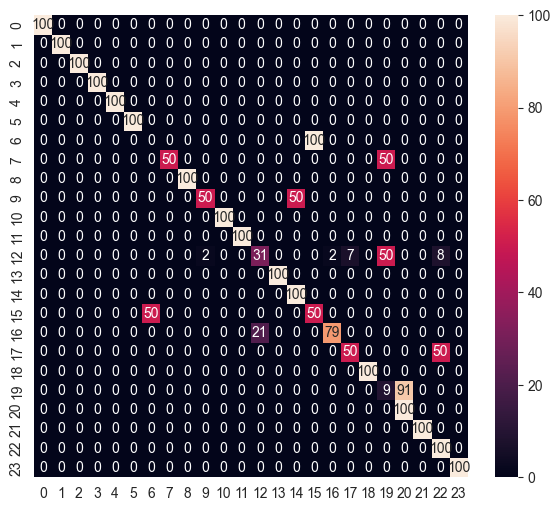

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       0.00      0.00      0.00       100
           7       1.00      0.50      0.67       100
           8       1.00      1.00      1.00       100
           9       0.96      0.50      0.66       100
          10       1.00      1.00      1.00       100
          11       1.00      1.00      1.00       100
          12       0.60      0.31      0.41       100
          13       1.00      1.00      1.00       100
          14       0.67      1.00      0.80       100
          15       0.33      0.50      0.40       100
          16       0.98      0.79      0.87       100
     

In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

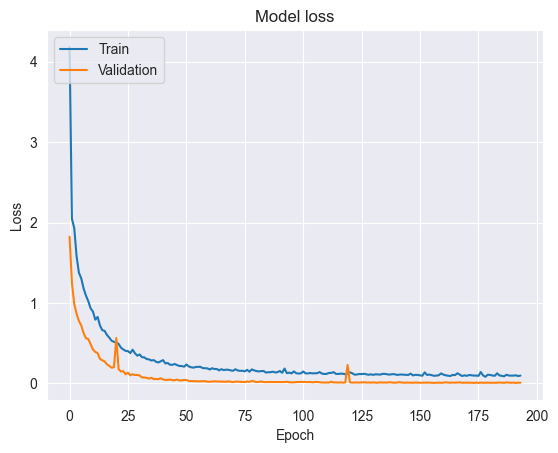

In [163]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

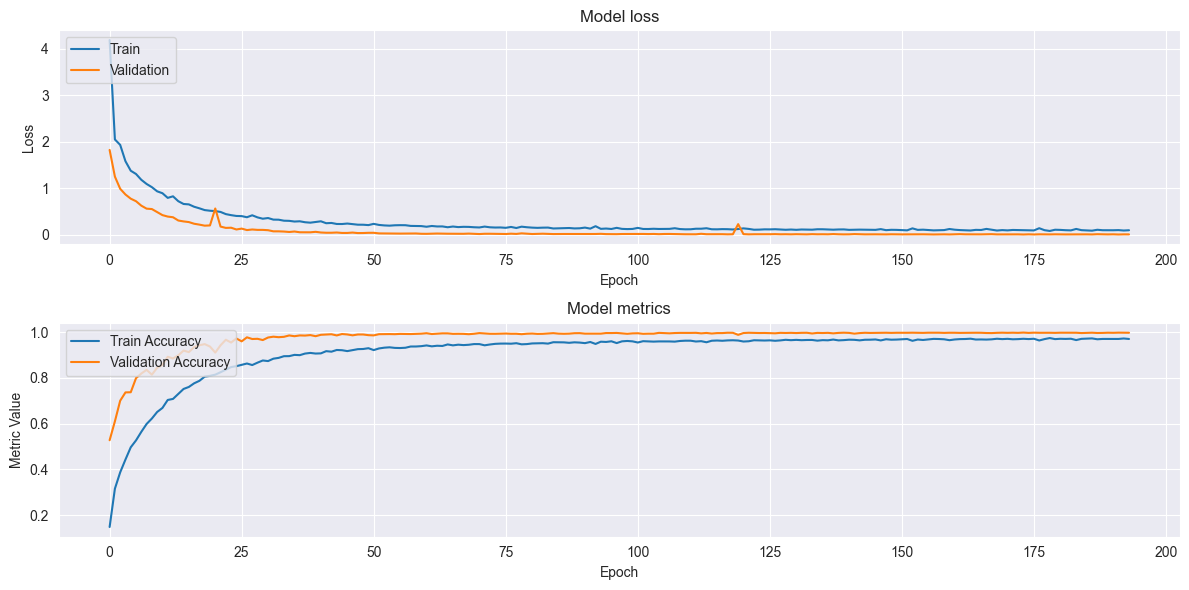

In [164]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()